## Rosalind BA9N - final bwm exact matching algorithm

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
import random as rand
import itertools

In [6]:
class BurrowsWheeler: 
    from collections import Counter
    """BWT & FM-index object for a text sequence"""

    def __init__(self, seq, k):
        """BW(seq,k) generates FM-index:\n BW.bwt, FirstOccurence, Checkpoint array, Partial suffix array \
        k- is the factor by which the FM-index (expt. bwt) is reduced from it's original size"""
        
        if seq [-1] != "$":
            seq += "$"
        self.seq = seq
        self.k = k
        self.bwt, self.psa = self.bw_transform()   # Burrows-Wheeler transform and k-suffix array
        self.first_occur = self.first_occurence()  # FirstOcc[symbol] pos in text
        self.checkpt = self.get_checkpoint()       # Checkpoint array

    def bw_transform(self): 
        """naive bwt with python sorted() on |text|^2 array"""
        cycles = sorted([(self.seq[i:] + self.seq[:i], i) for i in range(len(self.seq))], key= lambda x: x[0])
        bwt = ''.join(cycle[0][-1] for cycle in cycles)
        sa = [len(self.seq) - cycle[0].index('$')-1 for cycle in cycles]
        psa = [-1] * ((len(self.seq)-1)//self.k + 1)
        for suf in sa:
            if suf % self.k == 0:
                psa[suf//self.k] = sa.index(suf)
        return bwt, psa

    def first_occurence(self):
        """dict[symbol] = first index of symbol in sorted(bwt)"""
        first_occur = {}
        for i, symbol in enumerate(sorted(self.bwt)):
            if symbol not in first_occur.keys():
                first_occur[symbol] = i
        return first_occur

    def get_checkpoint(self):
        """Checkpoint matrix for pattern matching, every k-th row of count matrix"""
        alpha = sorted(set(self.bwt)) #self.bwt
        alpha.remove('$')
        count = {symbol:[0] for symbol in alpha}
        for i in range(self.k, len(self.bwt), self.k): #self.bwt
            c = Counter(self.bwt[i - self.k:i])
            for s in alpha:
                count[s].append(count[s][-1] + c[s])
        return count   
    
#     # not necessary here...
#     def decode(self):
#         """decodes the BWT to the original string text"""
#         last = [(symbol, self.count[symbol][index]) for index, symbol in enumerate(self.bwt)]
#         first = sorted(last, key = lambda x: x[0])
#         decoded = ''
#         symbol = ('$',0)
#         while len(decoded)<len(last):
#             symbol = first[last.index(symbol)]
#             decoded += symbol[0]
#         return decoded

    def pattern_match(self, pattern):
        
        """BW matching using first occur and count data, constant-time indexing"""
        top = 0
        bottom = len(self.bwt)
        while bottom > top:
            # case- match(es): return index pointers
            if not pattern:
                return (top, bottom)  
            symbol = pattern[-1]
            # case- no match, pattern has symbol not in text
            if symbol not in self.checkpt.keys():
                return None           
            
            # index top & bottom pointers using first_occ + checkpoint + counter
            c_top = self.first_occur[symbol] + self.checkpt[symbol][top//self.k]
            if top % self.k != 0:
                c_top += Counter(self.bwt[top - top%self.k: top])[symbol]
            
            c_bottom = self.first_occur[symbol] + self.checkpt[symbol][bottom//self.k]
            if bottom % self.k != 0:
                 c_bottom += Counter(self.bwt[bottom - bottom % self.k: bottom])[symbol]
            
            # set new pointers and remove symbol from pattern
            (top, bottom) = (c_top, c_bottom)
            pattern = pattern[:-1]
        
        # case- no match, bottom=top  
        return None 
    
    
    def multiple_pattern_match(self, patterns):
        """Returns a set of start indexes of all matches in text (all in one list right now)"""
        
        pattern_windows = list(map(self.pattern_match, patterns)) # PM for each pattern
        
        # recreate First/Last cols -> [(symbol, rank in last)]
        last = []
        for i, s in enumerate(self.bwt):
            if s == '$':
                last.append((s,0))
            else:
                last.append((s, self.checkpt[s][i//self.k]+ Counter(self.bwt[i - i%self.k: i])[s]))
        first = [(self.bwt[i],last[i][1]) for i in range(len(self.bwt))]
        first = sorted(first, key = lambda x: x[0])        
        results = []
        
        # Convert top-bottom windows -> start indexes
        for window in pattern_windows:
            
            # case- no-match-for-pattern 
            if not window:
                results.append(None)
            
            # case- pattern has >=1 match in text
              # window is the (top, bottom) indices in First for each pattern 
              # walk back in text by first/last property until find entry in psa
              # i's start pos. is psa[j] + steps(from i to j)
                
            else:
                starts = []
                for i in range(window[0], window[1]):
                    steps = 0
                    j = i       
                    while True:
                        if j in self.psa: 
                            starts.append(self.psa.index(j)*self.k + steps)
                            break
                        steps+=1
                        j = first.index(last[j]) 
                        
                results.append(sorted(starts))
        return results

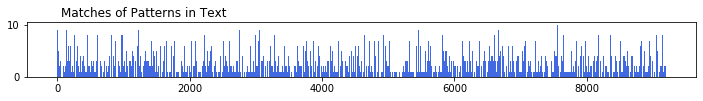

<Figure size 432x288 with 0 Axes>

In [7]:

with open('/Users/jasonmoggridge/Dropbox/Rosalind/Coursera_textbook_track/Course6/data/rosalind_ba9n.txt', 'r') as infile:
    dna = infile.readline().strip()
    patterns = [s.strip() for s in infile.readlines()]

k = 25
bwt = BurrowsWheeler(dna, k)
results = bwt.multiple_pattern_match(patterns)

solutions = set(itertools.chain(*[r for r in results if r]))
with open('rosalind_ba9n_out.txt', 'w') as outfile:
    outfile.write(' '.join(str(s) for s in solutions))

# # 1d scatter
# plt.figure(figsize=(12,1))
# plt.scatter(list(solutions), [rand.random() for _ in solutions], s=0.2, color='magenta', alpha= 0.5)
# plt.yticks([])
# plt.xlabel("Start postion")
# plt.suptitle("Matches of Patterns in Text", size = 12, y = 1.095,x =0.164, ha='left' )
# plt.show()
# plt.savefig("matches_scatter_ba9n.png", bbox_inches='tight')

# histogram
plt.figure(figsize=(12,1))
plt.hist(list(solutions), bins=1000, color='royalblue')
plt.suptitle("Matches of Patterns in Text", size = 12, y = 1.095,x =0.164, ha='left' )
plt.show()
plt.savefig("matches_histo_ba9n.png", bbox_inches='tight')

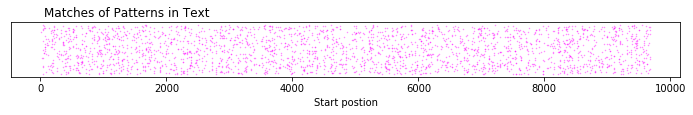

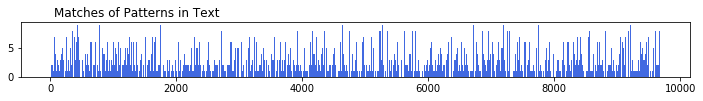

In [9]:
# import matplotlib.pyplot as plt
# import random as rand
# import itertools


with open('/Users/jasonmoggridge/Dropbox/Rosalind/Coursera_textbook_track/Course6/data/dataset_303_4.txt', 'r') as infile:
    dna = infile.readline().strip()
    patterns = [s.strip() for s in infile.readlines()]

k = 25
bwt = BurrowsWheeler(dna, k)
results = bwt.multiple_pattern_match(patterns)

solutions = set(itertools.chain(*[r for r in results if r]))
with open('dataset_303_4_out.txt', 'w') as outfile:
    outfile.write(' '.join(str(s) for s in solutions))

# 1d scatter
plt.figure(figsize=(12,1))
plt.scatter(list(solutions), [rand.random() for _ in solutions], s=0.2, color='magenta', alpha= 0.5)
plt.yticks([])
plt.xlabel("Start postion")
plt.suptitle("Matches of Patterns in Text", size = 12, y = 1.095,x =0.164, ha='left' )
plt.savefig("matches_scatter_ba9n.png", bbox_inches='tight')
plt.show()

# histogram
plt.figure(figsize=(12,1))
plt.hist(list(solutions), bins=1000, color='royalblue')
plt.suptitle("Matches of Patterns in Text", size = 12, y = 1.095,x =0.164, ha='left' )
plt.savefig("matches_histo_ba9n.png", bbox_inches='tight')
plt.show()


---



<br>

### Analysis of runtime and space of this algorithm
---

#### Running patternmatch for varying k and computing time and space for each

$ k = 2^x $: for x in range(2,7)

In [11]:
import itertools
import time
import sys
import matplotlib.pyplot as plt

#
with open('/Users/jasonmoggridge/Dropbox/Rosalind/Coursera_textbook_track/Course6/data/MultiplePatternMatching.txt', 'r') as infile:
    infile.readline()
    dna = infile.readline().strip()

    line = infile.readline().strip()
    patterns = []
    while line != 'Output':
        patterns.append(line)
        line = infile.readline().strip()
    solved = [int(x) for x in infile.readline().strip().split(' ')]
#

times = []
memories = []
k_range = [2**x for x in range(2,7)]
memories ={'bwt.bwt':[], 'bwt.checkpt':[], 'bwt.psa':[], 'bwt.first_occur':[]}

for k in k_range:
    print('working on k:', k)
    start = time.time()
    bwt = BurrowsWheeler(dna, k)
    results = bwt.multiple_pattern_match(patterns)
    times.append(float(time.time()-start))
    objs = [bwt.bwt, bwt.checkpt, bwt.first_occur, bwt.psa]
    for attrib in sorted(list(memories.keys())):
        if attrib == 'bwt.checkpt':
            objs.pop(0)
            memories[attrib].append(sum([sys.getsizeof(bwt.checkpt[s])/1000 for s in bwt.checkpt.keys()]))
        else:
            memories[attrib].append(sys.getsizeof(objs.pop(0))/1000)
#
total_memory = [sum([memories[a][i] for a in memories.keys()]) for i in range(len(k_range))]

working on k: 4
working on k: 8
working on k: 16
working on k: 32
working on k: 64


## Plot of space and memory used for each computation of Pattern Match(text, patterns)

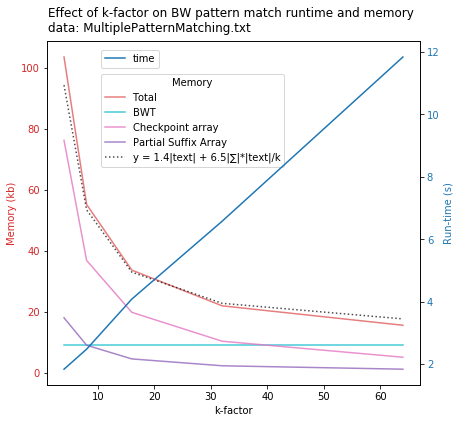

In [12]:
fig, ax1 = plt.subplots(figsize=(6.5,5.5))

color = 'tab:red'
ax1.set_xlabel('k-factor')
ax1.set_ylabel('Memory (kb)', color=color)
ax1.plot(k_range, total_memory, color=color, label = 'Total', alpha = 0.6)
ax1.tick_params(axis='y', labelcolor=color)

colrs = ['tab:cyan', 'tab:pink', 'tab:purple', 'tab:orange']
for name, key, colour in zip(['BWT', 'Checkpoint array', 'Partial Suffix Array'],memories.keys(), colrs):
    if key != 'bwt.first_occur':
        color = colour
        ax1.plot(k_range, memories[key], label=name, color= color, alpha = 0.8)

alpha, beta = 1.4, 6.5
model = [(alpha)*(len(dna) + (beta)*4*len(dna)/k)/1000 for k in k_range]
color = 'tab:red'
ax1.plot(k_range, model, label='y = {}|text| + {}|∑|*|text|/k'.format(alpha,beta), color='black',\
         alpha =0.7, linestyle=':')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Run-time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(k_range, times, color=color, label = 'time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(title = 'Memory', loc='center left', bbox_to_anchor=(0.13, 0.77))
ax2.legend(loc='center left', bbox_to_anchor=(0.13, 0.95))
plt.suptitle("Effect of k-factor on BW pattern match runtime and memory\ndata: MultiplePatternMatching.txt",\
         size = 12, y = 1.06,x =0.11, ha='left' )
plt.savefig("effect of k-factor.png", bbox_inches='tight')
###```